In [1]:
var openDigger = require('../src/open_digger')
var query = q => openDigger.driver.clickhouse.query(q, { format: 'JSONEachRow' });

# Clickhouse demo (Update at 2022.12.15)

This notebook is a comprehensive Clickhouse database demo to show how to use Clickhouse instance to analyze GitHub event data.

The content is from "Milovidov A., 2020. Everything You Ever Wanted To Know About GitHub (But Were Afraid To Ask), https://ghe.clickhouse.tech/".

## Counting stars

The `WatchEvent` is the event when someone gives a star to a repo.

In [2]:
query(`
SELECT COUNT() AS total_count
FROM gh_events
WHERE type = 'WatchEvent'
`).then(console.table);

┌─────────┬─────────────┐
│ (index) │ total_count │
├─────────┼─────────────┤
│    0    │ '314168026' │
└─────────┴─────────────┘


> There is no events when someone removes the star. This means that star removal is invisible, but it should be rare in any case, so we can calculate the approximate number of stars from these events.
> 
> Pay attention, the star counting here is incorrect because of the following reasons:
> 
> - The stars before 1/1/2015 are not counted by 'WatchEvent' because the data source GH Archive did not start recording Event API until 1/1/2015.
> - Some stars are removed or re-stared several times so it may lead to missing stars or duplicated stars.
> - `repo_name` may have been changed across the data.
> 
> So, our suggestions are:
> 
> - Use Github API to fetch the real-time star count.
> - Use `repo_id` instead of `repo_name` as the indexes of analysis.

There are over 300 million stars on GitHub!

Let's validate the star count by comparing it for Clickhosue repository:

In [4]:
query(`
SELECT COUNT() AS clickhouse_stars
FROM gh_events
WHERE type = 'WatchEvent' AND repo_name IN ('ClickHouse/ClickHouse', 'yandex/ClickHouse')
GROUP BY action
`).then(console.table);

┌─────────┬──────────────────┐
│ (index) │ clickhouse_stars │
├─────────┼──────────────────┤
│    0    │     '28005'      │
└─────────┴──────────────────┘


The number looks consistent with the real star count.

> The repository was moved from yandex/ClickHouse to ClickHouse/ClickHouse on October 2019, so we have to sum up the numbers for two repos.

## Top repositories by stars

This is the first report that comes to mind.

In [5]:
query(`
SELECT repo_name, COUNT() AS stars
FROM gh_events WHERE type = 'WatchEvent'
GROUP BY repo_name
ORDER BY stars DESC
LIMIT 20
`).then(console.table);

┌─────────┬──────────────────────────────────────────┬──────────┐
│ (index) │                repo_name                 │  stars   │
├─────────┼──────────────────────────────────────────┼──────────┤
│    0    │             '996icu/996.ICU'             │ '273033' │
│    1    │          'sindresorhus/awesome'          │ '249365' │
│    2    │    'kamranahmedse/developer-roadmap'     │ '238267' │
│    3    │               'vuejs/vue'                │ '232950' │
│    4    │  'jwasham/coding-interview-university'   │ '226860' │
│    5    │       'FreeCodeCamp/FreeCodeCamp'        │ '224460' │
│    6    │             'facebook/react'             │ '224437' │
│    7    │    'donnemartin/system-design-primer'    │ '213766' │
│    8    │         'tensorflow/tensorflow'          │ '198006' │
│    9    │       'freeCodeCamp/freeCodeCamp'        │ '189985' │
│   10    │ 'EbookFoundation/free-programming-books' │ '189249' │
│   11    │        'public-apis/public-apis'         │ '171752' │
│   12    

The top repository ever is "996.ICU" — it's not for software, but more like a project to improve awareness about work schedules in different Chinese companies. But wait... it's not the top repo. We see two copies of "FreeCodeCamp": FreeCodeCamp/FreeCodeCamp and freeCodeCamp/freeCodeCamp. If we sum up the stars it will be 224460 + 176141 = 400601 — more than "996.ICU". So, the top repository on GitHub is an educational resource.

Next we see: JavaScript framework, then Machine Learning framework, then another JavaScript framework, then the list of Awesome Awesomeness, then the JavaScript education resources, then another education project, another education project, UI framework, education, education, UI framework, JS something, CSS framework and finally in 17th place there is Linux. Let's stop at this point.

Bottomline: GitHub is full of JavaScript frameworks and education content. But don't jump to conclusions yet — we've only scratched the surface!

## Distribution of repositories by star count

By the way, what is the distribution of repositories by stars?

In [6]:
query(`SELECT exp10(floor(log10(c))) AS stars, uniq(name) AS repo_count
FROM
(
    SELECT
        repo_name AS name,
        COUNT() AS c
    FROM gh_events
    WHERE type = 'WatchEvent'
    GROUP BY name
)
GROUP BY stars
ORDER BY stars
`).then(console.table);

┌─────────┬────────┬────────────┐
│ (index) │ stars  │ repo_count │
├─────────┼────────┼────────────┤
│    0    │   1    │ '23145966' │
│    1    │   10   │ '1622539'  │
│    2    │  100   │  '274097'  │
│    3    │  1000  │  '36846'   │
│    4    │ 10000  │   '2576'   │
│    5    │ 100000 │    '33'    │
└─────────┴────────┴────────────┘


There are only 23 million repositories that have at least one star. There are only 1.6 million repositories with 10+ stars. Just 274 thousand repositories have over 100 stars, 36,846 have over 1k stars, 2,576 have over 10k stars and there are only 33 repositories with more than 100k stars.

## The total number of reposioties on GitHub

In [7]:
query(`
SELECT uniq(repo_name) AS total_repo
FROM gh_events
`).then(console.table);

┌─────────┬─────────────┐
│ (index) │ total_repo  │
├─────────┼─────────────┤
│    0    │ '269846507' │
└─────────┴─────────────┘


If we will take all stars and distribute uniformly across all the repositories, every repository will get 1.16 stars.

## How has the list of top repositories changed over the years?

We will look at the data from 2015 to 2021.

In [8]:
query(`
SELECT toYear(created_at) AS year, repo_name, COUNT() AS stars
FROM gh_events
WHERE type = 'WatchEvent' AND year <= 2021
GROUP BY repo_name, year
ORDER BY year, stars DESC
LIMIT 20 BY year
`).then(console.table);

┌─────────┬──────┬──────────────────────────────────────────────────┬──────────┐
│ (index) │ year │                    repo_name                     │  stars   │
├─────────┼──────┼──────────────────────────────────────────────────┼──────────┤
│    0    │ 2015 │           'FreeCodeCamp/FreeCodeCamp'            │ '38362'  │
│    1    │ 2015 │             'facebook/react-native'              │ '25337'  │
│    2    │ 2015 │              'sindresorhus/awesome'              │ '24361'  │
│    3    │ 2015 │                  'apple/swift'                   │ '23193'  │
│    4    │ 2015 │                 'facebook/react'                 │ '22924'  │
│    5    │ 2015 │         'jlevy/the-art-of-command-line'          │ '21722'  │
│    6    │ 2015 │             'NARKOZ/hacker-scripts'              │ '20093'  │
│    7    │ 2015 │                 'twbs/bootstrap'                 │ '19488'  │
│    8    │ 2015 │          'google/material-design-lite'           │ '17684'  │
│    9    │ 2015 │          

Looks into the data in 2020, the top repo is a Chinese educational resource to prepare for an algorithms interview. Actually, amost all of the top 10 are related to education. The only exceptions are: Deno — a JS runtime and CSSEGISandData/COVID-19 — a repo for COVID-19 data. Yes, I expected that 2020 would be about COVID-19 but happily enough it's not only about COVID-19.

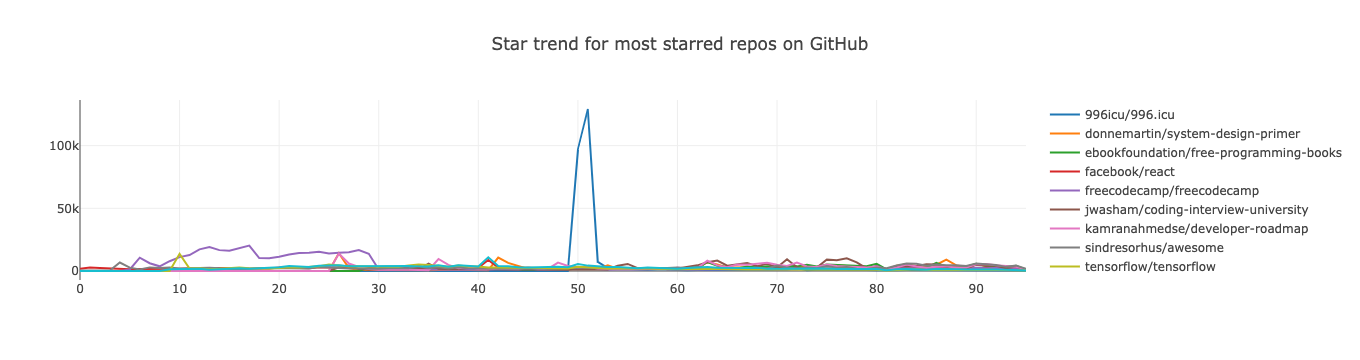

In [9]:
query(`
SELECT
    repo AS name,
    groupArrayInsertAt(toUInt32(c), toUInt64(dateDiff('month', toDate('2015-01-01'), month))) AS data
FROM
(
    SELECT
        lower(repo_name) AS repo,
        toStartOfMonth(created_at) AS month,
        count() AS c
    FROM gh_events
    WHERE type = 'WatchEvent' AND repo IN
    (
        SELECT lower(repo_name) AS repo
        FROM gh_events
        WHERE type = 'WatchEvent'
        GROUP BY repo
        ORDER BY count() DESC
        LIMIT 10
    )
    GROUP BY
        repo,
        month
)
GROUP BY repo
ORDER BY repo ASC
`).then(data => {
    openDigger.render.plotly(data.map(row => {
        return {
            y: row.data,
            name: row.name,
        }
    }), { title: 'Star trend for most starred repos on GitHub' });
});

## How has the total number of stars changed over time?

In [10]:
query(`
SELECT toYear(created_at) AS year, count() AS stars, bar(stars, 0, 50000000, 10) AS bar
FROM gh_events
WHERE type = 'WatchEvent'
GROUP BY year
ORDER BY year
`).then(console.table);

┌─────────┬──────┬────────────┬──────────────┐
│ (index) │ year │   stars    │     bar      │
├─────────┼──────┼────────────┼──────────────┤
│    0    │ 2015 │ '18950116' │    '███▋'    │
│    1    │ 2016 │ '26125809' │   '█████▏'   │
│    2    │ 2017 │ '32596796' │  '██████▌'   │
│    3    │ 2018 │ '36964092' │  '███████▍'  │
│    4    │ 2019 │ '45898177' │ '█████████▏' │
│    5    │ 2020 │ '49356912' │ '█████████▋' │
│    6    │ 2021 │ '50020755' │ '██████████' │
│    7    │ 2022 │ '54255369' │ '██████████' │
└─────────┴──────┴────────────┴──────────────┘


We see just steady linear growth with a YoY rate of about 25%.

## Who are all those people giving stars?

In [11]:
query(`
SELECT actor_login, COUNT() AS stars
FROM gh_events
WHERE type = 'WatchEvent'
GROUP BY actor_login
ORDER BY stars DESC
LIMIT 20
`).then(console.table);

┌─────────┬───────────────────┬──────────┐
│ (index) │    actor_login    │  stars   │
├─────────┼───────────────────┼──────────┤
│    0    │      'italy'      │ '264778' │
│    1    │      '4148'       │ '232489' │
│    2    │    'daweedkob'    │ '215744' │
│    3    │     'salifm'      │ '202516' │
│    4    │ 'aplus-developer' │ '134089' │
│    5    │  'CodePromoter'   │ '133102' │
│    6    │    'dinosoid'     │ '119101' │
│    7    │    'alineai18'    │ '111976' │
│    8    │    'fly51fly'     │ '90615'  │
│    9    │     'x0rzkov'     │ '74165'  │
│   10    │      'gkze'       │ '73206'  │
│   11    │     '5l1v3r1'     │ '72744'  │
│   12    │   'gauravssnl'    │ '56691'  │
│   13    │  'romanofficial'  │ '54139'  │
│   14    │ 'nikitavoloboev'  │ '52967'  │
│   15    │     'esneko'      │ '52202'  │
│   16    │     'trippup'     │ '51903'  │
│   17    │      'baslr'      │ '50270'  │
│   18    │       'ik5'       │ '48215'  │
│   19    │  'thanhtoan1196'  │ '48107'  │
└─────────┴

I checked the results: `italy` looks like an empty account... very suspicious.

In comparison, I only gave 41 stars:

In [12]:
query(`
SELECT actor_login, COUNT() AS stars
FROM gh_events
WHERE type = 'WatchEvent' AND actor_login = 'frank-zsy'
GROUP BY actor_login
`).then(console.table);

┌─────────┬─────────────┬───────┐
│ (index) │ actor_login │ stars │
├─────────┼─────────────┼───────┤
│    0    │ 'frank-zsy' │ '41'  │
└─────────┴─────────────┴───────┘


And here are my favorites storted by the total number of stars:

In [13]:
query(`
SELECT repo_name, COUNT() AS stars
FROM gh_events
WHERE type = 'WatchEvent' AND repo_name IN (
    SELECT repo_name
    FROM gh_events
    WHERE type = 'WatchEvent' AND actor_login = 'frank-zsy'
)
GROUP BY repo_name
ORDER BY stars DESC
LIMIT 20
`).then(console.table);

┌─────────┬───────────────────────────────────┬──────────┐
│ (index) │             repo_name             │  stars   │
├─────────┼───────────────────────────────────┼──────────┤
│    0    │     'getify/You-Dont-Know-JS'     │ '169952' │
│    1    │    'resume/resume.github.com'     │ '66750'  │
│    2    │        'huihut/interview'         │ '28777'  │
│    3    │        'docsifyjs/docsify'        │ '16730'  │
│    4    │        'thunlp/GNNPapers'         │ '14690'  │
│    5    │           'neo4j/neo4j'           │ '10292'  │
│    6    │         'sogou/workflow'          │ '10151'  │
│    7    │     'sxei/chrome-plugin-demo'     │  '7103'  │
│    8    │       'wuhan2020/wuhan2020'       │  '7043'  │
│    9    │        'answerdev/answer'         │  '4209'  │
│   10    │      'ByteLegend/ByteLegend'      │  '3598'  │
│   11    │         'actions/runner'          │  '3499'  │
│   12    │        'thunlp/NRLPapers'         │  '2715'  │
│   13    │       'alibaba/GraphScope'        │  '2199' 

## Repository affinity list

A quick question I'm eager to ask: what are the top repositories sorted by the number of stars from people who starred the ClickHouse reposiotry?

In [14]:
query(`
SELECT repo_name, COUNT() AS stars
FROM gh_events
WHERE type = 'WatchEvent' AND actor_login IN (
    SELECT actor_login
    FROM gh_events
    WHERE type = 'WatchEvent' AND repo_name IN ('ClickHouse/ClickHouse', 'yandex/ClickHouse')
) AND repo_name NOT IN ('ClickHouse/ClickHouse', 'yandex/ClickHouse')
GROUP BY repo_name
ORDER BY stars DESC
LIMIT 20
`).then(console.table);

┌─────────┬────────────────────────────────────┬────────┐
│ (index) │             repo_name              │ stars  │
├─────────┼────────────────────────────────────┼────────┤
│    0    │ 'donnemartin/system-design-primer' │ '8362' │
│    1    │      'tensorflow/tensorflow'       │ '8246' │
│    2    │            'golang/go'             │ '7549' │
│    3    │      'kubernetes/kubernetes'       │ '7432' │
│    4    │       'sindresorhus/awesome'       │ '7270' │
│    5    │           'pingcap/tidb'           │ '7089' │
│    6    │      'prometheus/prometheus'       │ '6828' │
│    7    │         'flutter/flutter'          │ '6411' │
│    8    │        'avelino/awesome-go'        │ '6335' │
│    9    │         'grafana/grafana'          │ '6306' │
│   10    │      'ant-design/ant-design'       │ '6166' │
│   11    │          'gin-gonic/gin'           │ '6161' │
│   12    │            'vuejs/vue'             │ '6133' │
│   13    │           'minio/minio'            │ '6035' │
│   14    │  '

It's Tensorflow and TiDB. Yes, ClickHouse is friends with TiDB (they are using the ClickHouse engin under the hood for analytical queries). Then golang, prometheus and kubernetes. The overall list is slightly biased towards data-intensive applications: database engines, distributed filesystems, data orcestration, etc.

## Finding friends through counting stars

Let me find a friend by the intersection on starred repositories.

In [15]:
query(`
WITH repo_name IN (
    SELECT repo_name
    FROM gh_events
    WHERE type = 'WatchEvent' AND actor_login = 'frank-zsy'
) AS is_my_repo
SELECT actor_login, SUM(is_my_repo) AS stars_my, SUM(NOT is_my_repo) AS stars_other, ROUND(stars_my / (38 + stars_other), 3) AS ratio
FROM gh_events
WHERE type = 'WatchEvent'
GROUP BY actor_login
ORDER BY ratio DESC
LIMIT 20
`).then(console.table);

┌─────────┬────────────────┬──────────┬─────────────┬───────┐
│ (index) │  actor_login   │ stars_my │ stars_other │ ratio │
├─────────┼────────────────┼──────────┼─────────────┼───────┤
│    0    │  'frank-zsy'   │   '41'   │     '0'     │ 1.079 │
│    1    │   'hx94113'    │   '25'   │     '1'     │ 0.641 │
│    2    │   'daydate'    │   '22'   │     '2'     │ 0.55  │
│    3    │ 'blindpirate'  │   '58'   │    '151'    │ 0.307 │
│    4    │ 'lidongze0629' │   '33'   │    '74'     │ 0.295 │
│    5    │    'wtfil'     │   '27'   │    '75'     │ 0.239 │
│    6    │  'Tara-Fuki'   │   '8'    │     '1'     │ 0.205 │
│    7    │   'RayProud'   │   '9'    │     '7'     │  0.2  │
│    8    │   'Jrmy-rbr'   │   '9'    │     '8'     │ 0.196 │
│    9    │   'hcl0908'    │   '7'    │     '1'     │ 0.179 │
│   10    │   'chenDSEE'   │   '7'    │     '2'     │ 0.175 │
│   11    │   'wzl12356'   │   '9'    │    '15'     │ 0.17  │
│   12    │   'Sophie36'   │   '7'    │     '5'     │ 0.163 │
│   13  

Here is my friends by data... and I don't know what to do with this list.

## Affinity by issues and PRs

Authors that contributed to ClikcHouse also contributed to what repositories?

In [16]:
query(`
SELECT repo_name, COUNT() AS prs, uniq(actor_login) AS authors
FROM gh_events
WHERE type = 'PullRequestEvent' AND action = 'opened' AND actor_login IN
(
    SELECT actor_login
    FROM gh_events
    WHERE type = 'PullRequestEvent' AND action = 'opened' AND repo_name IN ('yandex/ClickHouse', 'ClickHouse/ClickHouse')
) AND repo_name NOT LIKE '%ClickHouse%'
GROUP BY repo_name
ORDER BY authors DESC
LIMIT 20
`).then(console.table);

┌─────────┬───────────────────────────────────────────────────┬────────┬─────────┐
│ (index) │                     repo_name                     │  prs   │ authors │
├─────────┼───────────────────────────────────────────────────┼────────┼─────────┤
│    0    │             'apache/incubator-doris'              │ '527'  │  '31'   │
│    1    │                  'pingcap/tidb'                   │ '825'  │  '27'   │
│    2    │                  'apache/spark'                   │ '160'  │  '26'   │
│    3    │             'Homebrew/homebrew-core'              │  '65'  │  '25'   │
│    4    │                  'apache/flink'                   │ '327'  │  '24'   │
│    5    │             'yandex/clickhouse-jdbc'              │ '103'  │  '22'   │
│    6    │                'facebook/rocksdb'                 │  '43'  │  '19'   │
│    7    │               'StarRocks/starrocks'               │ '378'  │  '18'   │
│    8    │                 'grafana/grafana'                 │ '342'  │  '18'   │
│   

Authors that filed an issue in ClickHouse also filed issues in what repositories?

In [17]:
query(`
SELECT repo_name, COUNT() AS prs, uniq(actor_login) AS authors
FROM gh_events
WHERE type = 'IssuesEvent' AND action = 'opened' AND actor_login IN
(
    SELECT actor_login
    FROM gh_events
    WHERE type = 'IssuesEvent' AND action = 'opened' AND repo_name IN ('yandex/ClickHouse', 'ClickHouse/ClickHouse')
) AND repo_name NOT LIKE '%ClickHouse%'
GROUP BY repo_name
ORDER BY authors DESC
LIMIT 20
`).then(console.table);

┌─────────┬─────────────────────────────────┬───────┬─────────┐
│ (index) │            repo_name            │  prs  │ authors │
├─────────┼─────────────────────────────────┼───────┼─────────┤
│    0    │        'grafana/grafana'        │ '342' │  '120'  │
│    1    │           'golang/go'           │ '318' │  '101'  │
│    2    │ 'Altinity/clickhouse-operator'  │ '219' │  '82'   │
│    3    │  'mymarilyn/clickhouse-driver'  │ '88'  │  '62'   │
│    4    │ 'AlexAkulov/clickhouse-backup'  │ '160' │  '60'   │
│    5    │     'elastic/elasticsearch'     │ '152' │  '59'   │
│    6    │ 'Vertamedia/clickhouse-grafana' │ '118' │  '58'   │
│    7    │     'kubernetes/kubernetes'     │ '150' │  '56'   │
│    8    │        'ansible/ansible'        │ '87'  │  '51'   │
│    9    │   'apache/incubator-superset'   │ '161' │  '51'   │
│   10    │    'yandex/clickhouse-jdbc'     │ '79'  │  '50'   │
│   11    │         'pingcap/tidb'          │ '787' │  '50'   │
│   12    │    'apache/incubator-doris' 

## Repositories with the most stars over one day

In [18]:
query(`
SELECT repo_name, toDate(created_at) AS day, COUNT() AS stars
FROM gh_events
WHERE type = 'WatchEvent'
GROUP BY repo_name, day
ORDER BY stars DESC
LIMIT 1 BY repo_name
LIMIT 20
`).then(console.table);

┌─────────┬───────────────────────────────────────┬──────────────┬─────────┐
│ (index) │               repo_name               │     day      │  stars  │
├─────────┼───────────────────────────────────────┼──────────────┼─────────┤
│    0    │           '996icu/996.ICU'            │ '2019-03-29' │ '31429' │
│    1    │          'UsergeTeam/Userge'          │ '2022-01-02' │ '18943' │
│    2    │     'UsergeTeam/Userge-Assistant'     │ '2022-01-02' │ '18872' │
│    3    │           'M4cs/BabySploit'           │ '2019-09-08' │ '17707' │
│    4    │         'microsoft/Terminal'          │ '2019-05-07' │ '12779' │
│    5    │      'flightlessmango/MangoHud'       │ '2021-07-16' │ '9790'  │
│    6    │             'apple/swift'             │ '2015-12-04' │ '9318'  │
│    7    │        'TheBreakery/Bloomware'        │ '2022-02-07' │ '7667'  │
│    8    │        'ant-design/ant-design'        │ '2021-05-16' │ '7552'  │
│    9    │           'desktop/desktop'           │ '2020-11-16' │ '7070'  │

## Repositories with the highest growth YoY

In [19]:
query(`
WITH toYear(created_at) AS year
SELECT repo_name, SUM(year = 2021) AS stars2021, SUM(year = 2020) AS stars2020, ROUND(stars2021 / stars2020, 3) AS yoy
FROM gh_events
WHERE type = 'WatchEvent'
GROUP BY repo_name
HAVING MIN(created_at) <= '2020-01-01 00:00:00' AND stars2020 >= 1000
ORDER BY yoy DESC
LIMIT 20
`).then(console.table);

┌─────────┬─────────────────────────────────────────────────────┬───────────┬───────────┬───────┐
│ (index) │                      repo_name                      │ stars2021 │ stars2020 │  yoy  │
├─────────┼─────────────────────────────────────────────────────┼───────────┼───────────┼───────┤
│    0    │                  'doocs/leetcode'                   │  '8366'   │  '1000'   │ 8.366 │
│    1    │           'Developer-Y/cs-video-courses'            │  '10273'  │  '1881'   │ 5.461 │
│    2    │                 'appwrite/appwrite'                 │  '10909'  │  '2106'   │ 5.18  │
│    3    │                  'Ryujinx/Ryujinx'                  │  '7967'   │  '1720'   │ 4.632 │
│    4    │                 'authelia/authelia'                 │  '8911'   │  '2048'   │ 4.351 │
│    5    │             'ethereumbook/ethereumbook'             │  '4752'   │  '1111'   │ 4.277 │
│    6    │                'freqtrade/freqtrade'                │  '11151'  │  '2683'   │ 4.156 │
│    7    │        '

A Chinese repository [doocs/leetcode](https://github.com/doocs/leetcode) has grown more than 8 times in stars in 2021!

## Repositories with the worst stagnation

In [20]:
query(`
WITH toYear(created_at) AS year
SELECT repo_name, SUM(year = 2021) AS stars2021, SUM(year = 2020) AS stars2020, ROUND(stars2021 / stars2020, 3) AS yoy
FROM gh_events
WHERE type = 'WatchEvent'
GROUP BY repo_name
HAVING MIN(created_at) <= '2020-01-01 00:00:00' AND MAX(created_at) >= '2021-06-01 00:00:00' AND stars2020 >= 1000
ORDER BY yoy
LIMIT 20
`).then(console.table);

┌─────────┬─────────────────────────────────────────┬───────────┬───────────┬───────┐
│ (index) │                repo_name                │ stars2021 │ stars2020 │  yoy  │
├─────────┼─────────────────────────────────────────┼───────────┼───────────┼───────┤
│    0    │              'opencv/cvat'              │    '0'    │  '1242'   │   0   │
│    1    │              'hapijs/joi'               │    '0'    │  '1410'   │   0   │
│    2    │            'samdenty/gqless'            │    '0'    │  '2505'   │   0   │
│    3    │          'shuleisanshi/myblog'          │    '9'    │  '1406'   │ 0.006 │
│    4    │ 'mdbootstrap/bootstrap-material-design' │   '43'    │  '1737'   │ 0.025 │
│    5    │          'yuanming-hu/taichi'           │   '114'   │  '4309'   │ 0.026 │
│    6    │          'kbariotis/templates'          │   '54'    │  '1949'   │ 0.028 │
│    7    │          'luruke/browser-2020'          │   '248'   │  '8166'   │ 0.03  │
│    8    │         'WaykiChain/WaykiChain'         │ 

## Repositories with the most steady growth over time

In [21]:
query(`
SELECT repo_name, MAX(stars) AS daily_stars, SUM(stars) AS total_stars, ROUND(total_stars / daily_stars, 3) AS rate
FROM (
    SELECT repo_name, toDate(created_at) AS day, COUNT() AS stars
    FROM gh_events
    WHERE type = 'WatchEvent'
    GROUP BY repo_name, day
)
GROUP BY repo_name
ORDER BY rate DESC
LIMIT 20
`).then(console.table);

┌─────────┬─────────────────────────────────────┬─────────────┬─────────────┬─────────┐
│ (index) │              repo_name              │ daily_stars │ total_stars │  rate   │
├─────────┼─────────────────────────────────────┼─────────────┼─────────────┼─────────┤
│    0    │      'auth0/node-jsonwebtoken'      │    '18'     │   '16602'   │ 922.333 │
│    1    │          'powerline/fonts'          │    '28'     │   '24756'   │ 884.143 │
│    2    │            'fxsjy/jieba'            │    '34'     │   '29750'   │   875   │
│    3    │ 'zsh-users/zsh-syntax-highlighting' │    '18'     │   '15665'   │ 870.278 │
│    4    │         'cheeriojs/cheerio'         │    '29'     │   '23578'   │ 813.034 │
│    5    │        'WordPress/WordPress'        │    '20'     │   '15414'   │  770.7  │
│    6    │       'jaredhanson/passport'        │    '24'     │   '18286'   │ 761.917 │
│    7    │       'VundleVim/Vundle.vim'        │    '25'     │   '18812'   │ 752.48  │
│    8    │          'square/ret

## What is the best day of the week to catch a star?

In [22]:
query(`
SELECT toDayOfWeek(created_at) AS day, COUNT() AS stars, bar(stars, 0, 50000000, 10) AS bar
FROM gh_events
WHERE type = 'WatchEvent'
GROUP BY day
ORDER BY day
`).then(console.table);

┌─────────┬─────┬────────────┬──────────────┐
│ (index) │ day │   stars    │     bar      │
├─────────┼─────┼────────────┼──────────────┤
│    0    │  1  │ '49089155' │ '█████████▋' │
│    1    │  2  │ '50769320' │ '██████████' │
│    2    │  3  │ '50067794' │ '██████████' │
│    3    │  4  │ '49335589' │ '█████████▋' │
│    4    │  5  │ '46594976' │ '█████████▎' │
│    5    │  6  │ '33791462' │  '██████▋'   │
│    6    │  7  │ '34519730' │  '██████▊'   │
└─────────┴─────┴────────────┴──────────────┘


It is Tuesday! Definitely not the weekend. Maybe Wednesday or Thursday, but not Monday or Friday.

## The total number of users on GitHub

In [23]:
query(`
SELECT uniq(actor_login) AS user_count FROM gh_events
`).then(console.table);

┌─────────┬────────────┐
│ (index) │ user_count │
├─────────┼────────────┤
│    0    │ '52240194' │
└─────────┴────────────┘


52.2 million. Actually, these are users that are not only registered but also participated at least once in ... something.

Total number of users that gave at least one star:

In [24]:
query(`
SELECT uniq(actor_login) AS user_count
FROM gh_events
WHERE type = 'WatchEvent'
`).then(console.table);

┌─────────┬────────────┐
│ (index) │ user_count │
├─────────┼────────────┤
│    0    │ '15146658' │
└─────────┴────────────┘


Just 15 million. I've heard that some people don't give stars. They just do their job instead.

Total number of users with at least one push:

In [25]:
query(`
SELECT uniq(actor_login) AS user_count
FROM gh_events
WHERE type = 'PushEvent'
`).then(console.table);

┌─────────┬────────────┐
│ (index) │ user_count │
├─────────┼────────────┤
│    0    │ '28521474' │
└─────────┴────────────┘


There are actually more people who pushed code than those who gave stars.

Total number of users with at least one created PR:

In [26]:
query(`
SELECT uniq(actor_login) AS user_count
FROM gh_events
WHERE type = 'PullRequestEvent' AND action = 'opened'
`).then(console.table);

┌─────────┬────────────┐
│ (index) │ user_count │
├─────────┼────────────┤
│    0    │ '9473912'  │
└─────────┴────────────┘


## Stars from heavy GitHub users

What if we count top starred repositories but only from those who made at least one PR in at least one repo?

In [27]:
query(`
SELECT repo_name, COUNT() AS count
FROM gh_events
WHERE type = 'WatchEvent' AND actor_login IN (
    SELECT actor_login
    FROM gh_events
    WHERE type = 'PullRequestEvent' AND action = 'opened'
)
GROUP BY repo_name
ORDER BY count DESC
LIMIT 20
`).then(console.table);

┌─────────┬──────────────────────────────────────────┬──────────┐
│ (index) │                repo_name                 │  count   │
├─────────┼──────────────────────────────────────────┼──────────┤
│    0    │    'kamranahmedse/developer-roadmap'     │ '148296' │
│    1    │          'sindresorhus/awesome'          │ '145620' │
│    2    │             'facebook/react'             │ '145283' │
│    3    │    'donnemartin/system-design-primer'    │ '142579' │
│    4    │               'vuejs/vue'                │ '131573' │
│    5    │  'jwasham/coding-interview-university'   │ '131529' │
│    6    │        'getify/You-Dont-Know-JS'         │ '119915' │
│    7    │         'tensorflow/tensorflow'          │ '112417' │
│    8    │        'public-apis/public-apis'         │ '104734' │
│    9    │     'trekhleb/javascript-algorithms'     │ '104199' │
│   10    │ 'EbookFoundation/free-programming-books' │ '100352' │
│   11    │    'danistefanovic/build-your-own-x'     │ '99590'  │
│   12    

The list is similar to the overall top list.

What if we take authors who have made at least 10 PRs?

In [28]:
query(`
SELECT repo_name, COUNT() AS count
FROM gh_events
WHERE type = 'WatchEvent' AND actor_login IN (
    SELECT actor_login
    FROM gh_events
    WHERE type = 'PullRequestEvent' AND action = 'opened'
    GROUP BY actor_login
    HAVING COUNT() >= 10
)
GROUP BY repo_name
ORDER BY count DESC
LIMIT 20
`).then(console.table);

┌─────────┬──────────────────────────────────────────┬─────────┐
│ (index) │                repo_name                 │  count  │
├─────────┼──────────────────────────────────────────┼─────────┤
│    0    │             'facebook/react'             │ '67824' │
│    1    │          'sindresorhus/awesome'          │ '65613' │
│    2    │    'donnemartin/system-design-primer'    │ '64754' │
│    3    │    'kamranahmedse/developer-roadmap'     │ '64510' │
│    4    │        'getify/You-Dont-Know-JS'         │ '57877' │
│    5    │               'vuejs/vue'                │ '55353' │
│    6    │  'jwasham/coding-interview-university'   │ '53286' │
│    7    │    'danistefanovic/build-your-own-x'     │ '48453' │
│    8    │     'trekhleb/javascript-algorithms'     │ '47901' │
│    9    │         'tensorflow/tensorflow'          │ '45899' │
│   10    │        'public-apis/public-apis'         │ '45466' │
│   11    │           'airbnb/javascript'            │ '45104' │
│   12    │             '

If we only count software, the list looks like this: React, Vue, Tensorflow, Linux, Flutter, Golang.

## Repositories with the maximum amount of pull requests

In [29]:
query(`
SELECT repo_name, COUNT() AS count, uniq(actor_login)
FROM gh_events
WHERE type = 'PullRequestEvent' AND action = 'opened'
GROUP BY repo_name
ORDER BY count DESC
LIMIT 20
`).then(console.table);

┌─────────┬───────────────────────────────────────────┬──────────┬───────────────────┐
│ (index) │                 repo_name                 │  count   │ uniq(actor_login) │
├─────────┼───────────────────────────────────────────┼──────────┼───────────────────┤
│    0    │     'google-test/signcla-probe-repo'      │ '443997' │        '5'        │
│    1    │      'WolseyBankWitness/rediffusion'      │ '414593' │        '7'        │
│    2    │   'mhutchinson/mhutchinson-distributor'   │ '253720' │        '6'        │
│    3    │              'NixOS/nixpkgs'              │ '164047' │      '5892'       │
│    4    │  'everypolitician/everypolitician-data'   │ '157464' │       '18'        │
│    5    │       'actions-canary/ForkPRCanary'       │ '120726' │        '5'        │
│    6    │    'google-test/signclav2-probe-repo'     │ '120396' │        '3'        │
│    7    │         'Homebrew/homebrew-core'          │ '107819' │      '7579'       │
│    8    │     'brianchandotcom/liferay-po

Here we can see some very specific data. The top repository looks like a test repository where you can check signing a CLA. But there are only 5 users with PRs and they are obviously bots.

Conclusion: if there are many pull requests from a small number of users, it means that this is just a part of some automated process.

No. 4 is the package repository for Nix OS. It's quite understandable — if you want your package to be in the OS, just make a pull request. And there are a lot of packages. The same for No. 8 — Homebrew.

Repositories with the maximum amount of pull request contributors:

In [30]:
query(`
SELECT repo_name, COUNT() AS count, uniq(actor_login) AS u
FROM gh_events
WHERE type = 'PullRequestEvent' AND action = 'opened'
GROUP BY repo_name
ORDER BY u DESC
LIMIT 20
`).then(console.table);

┌─────────┬─────────────────────────────────────────────────────────────────────────┬──────────┬─────────┐
│ (index) │                                repo_name                                │  count   │    u    │
├─────────┼─────────────────────────────────────────────────────────────────────────┼──────────┼─────────┤
│    0    │                'firstcontributions/first-contributions'                 │ '50505'  │ '46345' │
│    1    │                            'jlord/patchwork'                            │ '43375'  │ '37724' │
│    2    │                  'google/it-cert-automation-practice'                   │ '24274'  │ '23303' │
│    3    │                          'octocat/Spoon-Knife'                          │ '21925'  │ '19905' │
│    4    │                    'DefinitelyTyped/DefinitelyTyped'                    │ '46376'  │ '17479' │
│    5    │                 'zero-to-mastery/start-here-guidelines'                 │ '16198'  │ '14225' │
│    6    │                          

Repository "first-contribution" is the obvious case: a repository that teaches you how to make a pull request... by allowing you to make a pull request to this repository. "patchwork" is similar. Most of the repositories in this list are similar.

## Repositories with the maxmium amount of issues.

In [31]:
query(`
SELECT lower(repo_name) AS n, COUNT() AS c, uniq(actor_login) AS u
FROM gh_events
WHERE type = 'IssuesEvent' AND action = 'opened'
GROUP BY n
ORDER BY c DESC
LIMIT 20
`).then(console.table);

┌─────────┬────────────────────────────────────────┬───────────┬─────────┐
│ (index) │                   n                    │     c     │    u    │
├─────────┼────────────────────────────────────────┼───────────┼─────────┤
│    0    │             'pddemo/demo'              │ '1192076' │  '11'   │
│    1    │     'koorellasuresh/ukregiontest'      │ '379340'  │   '4'   │
│    2    │  'planft/planft-marketplace-comments'  │ '178488'  │   '2'   │
│    3    │         'lstjsuperman/fabric'          │ '161627'  │   '1'   │
│    4    │           'microsoft/vscode'           │ '143417'  │ '63840' │
│    5    │        'the-barserkou/comments'        │ '133124'  │   '2'   │
│    6    │       'jlippold/tweakcompatible'       │ '126698'  │ '11260' │
│    7    │             'nexity/testa'             │ '118867'  │   '1'   │
│    8    │      'adguardteam/adguardfilters'      │ '118285'  │ '1038'  │
│    9    │          'webcompat/web-bugs'          │ '109070'  │ '5962'  │
│   10    │        'ramos

The first repository has a funny description: "demo: A new issue is created in this repo every minute". The 2nd repository no longer exists.

The first meaningful result is VSCode with more than 143k issues and 63k authors. And the issues are real.

Conclusion: if a repository has a high number of issues, maybe issues are created automatically.

Let's add a cutoff at 1000 stars to distinguish the real issues from robot ones.

In [32]:
query(`
WITH type = 'IssuesEvent' AND action = 'opened' AS issue_created
SELECT repo_name, SUM(issue_created) AS c, uniqIf(actor_login, issue_created) AS u, SUM(type = 'WatchEvent') AS stars
FROM gh_events
WHERE type IN ('IssuesEvent', 'WatchEvent')
GROUP BY repo_name
HAVING stars >= 1000
ORDER BY c DESC
LIMIT 20
`).then(console.table);

┌─────────┬──────────────────────────────┬──────────┬─────────┬──────────┐
│ (index) │          repo_name           │    c     │    u    │  stars   │
├─────────┼──────────────────────────────┼──────────┼─────────┼──────────┤
│    0    │ 'AdguardTeam/AdguardFilters' │ '118285' │ '1038'  │  '2187'  │
│    1    │      'microsoft/vscode'      │ '78388'  │ '40264' │ '77929'  │
│    2    │      'flutter/flutter'       │ '73360'  │ '27182' │ '166097' │
│    3    │  'MicrosoftDocs/azure-docs'  │ '66350'  │ '31133' │  '8643'  │
│    4    │      'Microsoft/vscode'      │ '65029'  │ '27015' │ '81672'  │
│    5    │   'ron190/jsql-injection'    │ '63344'  │  '46'   │  '1255'  │
│    6    │       'elastic/kibana'       │ '45068'  │ '5125'  │ '16688'  │
│    7    │   'cockroachdb/cockroach'    │ '43798'  │ '1455'  │ '25886'  │
│    8    │         'golang/go'          │ '42495'  │ '13725' │ '118140' │
│    9    │   'kubernetes/kubernetes'    │ '36290'  │ '10514' │ '93091'  │
│   10    │     'godoteng

Now it looks like a reasonable list of the top repositories.

And for the next report, let's sort by the number of issue authors:

In [33]:
query(`
WITH type = 'IssuesEvent' AND action = 'opened' AS issue_created
SELECT repo_name, SUM(issue_created) AS c, uniqIf(actor_login, issue_created) AS u, SUM(type = 'WatchEvent') AS stars
FROM gh_events
WHERE type IN ('IssuesEvent', 'WatchEvent')
GROUP BY repo_name
ORDER BY u DESC
LIMIT 20
`).then(console.table);

┌─────────┬───────────────────────────────────────────────────────────────┬──────────┬─────────┬──────────┐
│ (index) │                           repo_name                           │    c     │    u    │  stars   │
├─────────┼───────────────────────────────────────────────────────────────┼──────────┼─────────┼──────────┤
│    0    │                      'microsoft/vscode'                       │ '78388'  │ '40264' │ '77929'  │
│    1    │                  'MicrosoftDocs/azure-docs'                   │ '66350'  │ '31133' │  '8643'  │
│    2    │                       'flutter/flutter'                       │ '73360'  │ '27182' │ '166097' │
│    3    │                      'Microsoft/vscode'                       │ '65029'  │ '27015' │ '81672'  │
│    4    │                    'tensorflow/tensorflow'                    │ '35063'  │ '20067' │ '198006' │
│    5    │                    'facebook/react-native'                    │ '22818'  │ '13912' │ '123403' │
│    6    │                 

## Repositories with the most people who have push access

In [2]:
query(`
SELECT repo_name, uniqIf(actor_login, type = 'PushEvent') AS u, SUM(type = 'WatchEvent') AS stars
FROM gh_events
WHERE type IN ('PushEvent', 'WatchEvent') AND toYear(created_at) <= 2020
GROUP BY repo_name
ORDER BY u DESC
LIMIT 20
`).then(console.table);

┌─────────┬───────────────────────────────────────────────────────────────┬────────┬─────────┐
│ (index) │                           repo_name                           │   u    │  stars  │
├─────────┼───────────────────────────────────────────────────────────────┼────────┼─────────┤
│    0    │ 'githubschool/open-enrollment-classes-introduction-to-github' │ '7850' │  '921'  │
│    1    │             'githubschool/on-demand-github-pages'             │ '1100' │  '89'   │
│    2    │                      'llvm/llvm-project'                      │ '840'  │ '7534'  │
│    3    │                'HNGInternship/HNGInternship4'                 │ '518'  │  '44'   │
│    4    │                  'bioconda/bioconda-recipes'                  │ '467'  │ '1356'  │
│    5    │           'cs480-projects/cs480-projects.github.io'           │ '449'  │  '15'   │
│    6    │                        'odoo-dev/odoo'                        │ '440'  │  '96'   │
│    7    │                      'hnginterns/hngfu

The first one is educational. It's really fantastic to have almost 8 thousand people pushing to the repository. Maybe it's just a development model where they are giving access to separate branches for a user or organization?

What about repositories with the most people who have push access to the main branch.

In [3]:
query(`
SELECT repo_name, uniqIf(actor_login, type = 'PushEvent' AND match(push_ref, '/(main|master)$')) AS u, SUM(type = 'WatchEvent') AS stars
FROM gh_events
WHERE type IN ('PushEvent', 'WatchEvent') AND toYear(created_at) <= 2020
GROUP BY repo_name
ORDER BY u DESC
LIMIT 20
`).then(console.table);

┌─────────┬───────────────────────────────────────────────────────────────┬────────┬─────────┐
│ (index) │                           repo_name                           │   u    │  stars  │
├─────────┼───────────────────────────────────────────────────────────────┼────────┼─────────┤
│    0    │ 'githubschool/open-enrollment-classes-introduction-to-github' │ '5599' │  '921'  │
│    1    │                      'llvm/llvm-project'                      │ '838'  │ '7534'  │
│    2    │             'githubschool/on-demand-github-pages'             │ '808'  │  '89'   │
│    3    │                'HNGInternship/HNGInternship4'                 │ '517'  │  '44'   │
│    4    │           'cs480-projects/cs480-projects.github.io'           │ '449'  │  '15'   │
│    5    │                      'hnginterns/hngfun'                      │ '437'  │  '33'   │
│    6    │                  'bioconda/bioconda-recipes'                  │ '432'  │ '1356'  │
│    7    │                 'tencentyun/qcloud-doc

It's almost the same.

## Repositories with the maximum number of accepted invitations

In [4]:
query(`
SELECT repo_name, SUM(type = 'MemberEvent') AS invitations, SUM(type = 'WatchEvent') AS stars
FROM gh_events
WHERE type IN ('MemberEvent', 'WatchEvent')
GROUP BY repo_name
HAVING stars >= 100
ORDER BY invitations DESC
LIMIT 20
`).then(console.table);

┌─────────┬───────────────────────────────────────────────────────────────┬─────────────┬─────────┐
│ (index) │                           repo_name                           │ invitations │  stars  │
├─────────┼───────────────────────────────────────────────────────────────┼─────────────┼─────────┤
│    0    │ 'githubschool/open-enrollment-classes-introduction-to-github' │   '10309'   │  '921'  │
│    1    │                  'openjournals/joss-reviews'                  │   '2626'    │  '638'  │
│    2    │             'githubschool/on-demand-github-pages'             │   '1611'    │  '135'  │
│    3    │                    'MasteringNuxt/NuxtBnB'                    │   '1554'    │  '229'  │
│    4    │                         'zulip/zulip'                         │   '1158'    │ '18487' │
│    5    │               'MasteringNuxt/mastering-nuxt-3'                │    '956'    │  '162'  │
│    6    │            'InfiniteFlightAirportEditing/Airports'            │    '717'    │  '235'  │


## Most forked repositories

In [5]:
query(`
SELECT repo_name, COUNT() AS forks
FROM gh_events
WHERE type = 'ForkEvent'
GROUP BY repo_name
ORDER BY forks DESC
LIMIT 20
`).then(console.table);

┌─────────┬───────────────────────────────────────────┬──────────┐
│ (index) │                 repo_name                 │  forks   │
├─────────┼───────────────────────────────────────────┼──────────┤
│    0    │           'jtleek/datasharing'            │ '213462' │
│    1    │           'octocat/Spoon-Knife'           │ '158491' │
│    2    │      'rdpeng/ProgrammingAssignment2'      │ '134685' │
│    3    │          'tensorflow/tensorflow'          │ '106605' │
│    4    │            'github/gitignore'             │ '103723' │
│    5    │           'LSPosed/MagiskOnWSA'           │ '96972'  │
│    6    │ 'SmartThingsCommunity/SmartThingsPublic'  │ '93810'  │
│    7    │             'twbs/bootstrap'              │ '87259'  │
│    8    │      'nightscout/cgm-remote-monitor'      │ '83178'  │
│    9    │ 'Pierian-Data/Complete-Python-3-Bootcamp' │ '79627'  │
│   10    │          'barryclark/jekyll-now'          │ '77921'  │
│   11    │ 'firstcontributions/first-contributions'  │ '64351

If we filter out repositories that have their main purpose to be forked, the clear winner is TensorFlow, then Bootstrap, OpenCV and React.

## Proportions between stars and forks

Let's check the proportion of stars and forks.

In [6]:
query(`
SELECT repo_name, SUM(type = 'ForkEvent') AS forks, SUM(type = 'WatchEvent') AS stars, ROUND(stars/forks, 3) AS ratio
FROM gh_events
WHERE type IN ('ForkEvent', 'WatchEvent')
GROUP BY repo_name
ORDER BY forks DESC
LIMIT 20
`).then(console.table);

┌─────────┬───────────────────────────────────────────┬──────────┬──────────┬───────┐
│ (index) │                 repo_name                 │  forks   │  stars   │ ratio │
├─────────┼───────────────────────────────────────────┼──────────┼──────────┼───────┤
│    0    │           'jtleek/datasharing'            │ '213462' │  '6308'  │ 0.03  │
│    1    │           'octocat/Spoon-Knife'           │ '158491' │  '5262'  │ 0.033 │
│    2    │      'rdpeng/ProgrammingAssignment2'      │ '134685' │  '1009'  │ 0.007 │
│    3    │          'tensorflow/tensorflow'          │ '106605' │ '198015' │ 1.857 │
│    4    │            'github/gitignore'             │ '103723' │ '132948' │ 1.282 │
│    5    │           'LSPosed/MagiskOnWSA'           │ '96972'  │ '19957'  │ 0.206 │
│    6    │ 'SmartThingsCommunity/SmartThingsPublic'  │ '93810'  │  '2980'  │ 0.032 │
│    7    │             'twbs/bootstrap'              │ '87259'  │ '119637' │ 1.371 │
│    8    │      'nightscout/cgm-remote-monitor'      

We can see a separation. Some repositories are "for forks" like the "octocat/Spoon-Knife" — they either have fork as a purpose of the repo or some of them represent a template to base something new on. Some repositories are "for stars" — usually it's not software but some text content, like "996icu/996.ICU".

The overall proportion between stars and forks:

In [7]:
query(`
SELECT SUM(type = 'ForkEvent') AS forks, SUM(type = 'WatchEvent') AS stars, ROUND(stars/forks, 2) AS ratio
FROM gh_events
WHERE type IN ('ForkEvent', 'WatchEvent')
`).then(console.table);

┌─────────┬─────────────┬─────────────┬───────┐
│ (index) │    forks    │    stars    │ ratio │
├─────────┼─────────────┼─────────────┼───────┤
│    0    │ '113012217' │ '314184812' │ 2.78  │
└─────────┴─────────────┴─────────────┴───────┘


And the result is higher for more popular reposioties:

In [8]:
query(`
SELECT SUM(forks) AS forks, SUM(stars) AS stars, ROUND(stars/forks, 2) AS ratio
FROM (
    SELECT SUM(type = 'ForkEvent') AS forks, SUM(type = 'WatchEvent') AS stars
    FROM gh_events
    WHERE type IN ('ForkEvent', 'WatchEvent')
    GROUP BY repo_name
    HAVING stars > 100
)
`).then(console.table);

┌─────────┬────────────┬─────────────┬───────┐
│ (index) │   forks    │    stars    │ ratio │
├─────────┼────────────┼─────────────┼───────┤
│    0    │ '58425498' │ '228102208' │  3.9  │
└─────────┴────────────┴─────────────┴───────┘


## Issue with the most comments

Total number of issue comments on GitHub:

In [9]:
query(`
SELECT COUNT()
FROM gh_events
WHERE type = 'IssueCommentEvent' AND action = 'created'
`).then(console.table);

┌─────────┬─────────────┐
│ (index) │   count()   │
├─────────┼─────────────┤
│    0    │ '322930677' │
└─────────┴─────────────┘


The top repositories by issue comments:

In [10]:
query(`
SELECT repo_name, COUNT()
FROM gh_events
WHERE type = 'IssueCommentEvent' AND action = 'created'
GROUP BY repo_name
ORDER BY COUNT() DESC
LIMIT 20
`).then(console.table);

┌─────────┬──────────────────────────────────┬───────────┐
│ (index) │            repo_name             │  count()  │
├─────────┼──────────────────────────────────┼───────────┤
│    0    │     'kubernetes/kubernetes'      │ '1707150' │
│    1    │          'apache/spark'          │ '788626'  │
│    2    │         'rust-lang/rust'         │ '683432'  │
│    3    │         'elastic/kibana'         │ '602998'  │
│    4    │ 'google-test/signcla-probe-repo' │ '583011'  │
│    5    │     'microsoft/winget-pkgs'      │ '554820'  │
│    6    │          'cms-sw/cmssw'          │ '541578'  │
│    7    │         'NixOS/nixpkgs'          │ '530175'  │
│    8    │        'flutter/flutter'         │ '514855'  │
│    9    │        'openshift/origin'        │ '506718'  │
│   10    │       'openshift/release'        │ '438689'  │
│   11    │ 'brianchandotcom/liferay-portal' │ '428312'  │
│   12    │    'MicrosoftDocs/azure-docs'    │ '365503'  │
│   13    │          'istio/istio'           │ '360877' 

The proportion between issue comments and issues:

In [11]:
query(`
SELECT repo_name, COUNT(action = 'created') AS comments, uniq(issue_number) AS issues, ROUND(comments/issues, 2) AS ratio
FROM gh_events
WHERE type = 'IssueCommentEvent'
GROUP BY repo_name
ORDER BY comments DESC
LIMIT 20
`).then(console.table);

┌─────────┬──────────────────────────────────┬───────────┬──────────┬───────┐
│ (index) │            repo_name             │ comments  │  issues  │ ratio │
├─────────┼──────────────────────────────────┼───────────┼──────────┼───────┤
│    0    │     'kubernetes/kubernetes'      │ '1707150' │ '102577' │ 16.64 │
│    1    │          'apache/spark'          │ '788626'  │ '35018'  │ 22.52 │
│    2    │         'rust-lang/rust'         │ '683432'  │ '83068'  │ 8.23  │
│    3    │         'elastic/kibana'         │ '602998'  │ '132884' │ 4.54  │
│    4    │ 'google-test/signcla-probe-repo' │ '583011'  │ '447312' │  1.3  │
│    5    │     'microsoft/winget-pkgs'      │ '554820'  │ '88524'  │ 6.27  │
│    6    │          'cms-sw/cmssw'          │ '541578'  │ '33245'  │ 16.29 │
│    7    │         'NixOS/nixpkgs'          │ '530175'  │ '136636' │ 3.88  │
│    8    │        'flutter/flutter'         │ '514855'  │ '102396' │ 5.03  │
│    9    │        'openshift/origin'        │ '506718'  │ '2623

Kubernetes has the most active discussions among the top repositories. In contrast, the repository with the least comments per issue. And "google-test/signcla-probe-repo", is clearly not for discussions.

Now let's find the most active issues...

In [12]:
query(`
SELECT repo_name, issue_number, COUNT() AS comments
FROM gh_events
WHERE type = 'IssueCommentEvent' AND action = 'created'
GROUP BY repo_name, issue_number
ORDER BY comments DESC
LIMIT 20
`).then(console.table);

┌─────────┬──────────────────────────────────────────────────────────┬──────────────┬──────────┐
│ (index) │                        repo_name                         │ issue_number │ comments │
├─────────┼──────────────────────────────────────────────────────────┼──────────────┼──────────┤
│    0    │           'gafusion/regression_notifications'            │      1       │ '21888'  │
│    1    │                   'sauron-demo/sauron'                   │      1       │ '21022'  │
│    2    │             'odoo-mergebot-testing-org/repo'             │      1       │ '13153'  │
│    3    │               'HarshCasper/Rotten-Scripts'               │      7       │ '11717'  │
│    4    │                  'Blaquez-home/roslyn'                   │      2       │ '11071'  │
│    5    │                   'keycloak/keycloak'                    │      60      │  '8397'  │
│    6    │           'zeit-github-test/github-utils-test'           │      1       │  '8295'  │
│    7    │             'odoo-

The top repositories have the most comments in their first issue. It looks like technical comments made by some script. Nothing interesting here, and actually I did not find these comments on the GitHub website (maybe they have already been deleted).

## Top commented issues for each of the top repositories

In [13]:
query(`
SELECT
    CONCAT('https://github.com/', repo_name, '/issues/', toString(issue_number)) AS URL,
    MAX(comments),
    argMax(authors, comments) AS authors,
    argMax(issue_number, comments) AS issue_number,
    SUM(stars) AS stars
FROM (
    SELECT * FROM (
        SELECT repo_name, issue_number, COUNT() AS comments, uniq(actor_login) AS authors
        FROM gh_events
        WHERE type = 'IssueCommentEvent' AND action = 'created'
        GROUP BY repo_name, issue_number
        HAVING authors >= 10
    ) AS t1
    INNER JOIN
    (
        SELECT repo_name, COUNT() AS stars
        FROM gh_events
        WHERE type = 'WatchEvent'
        GROUP BY repo_name
        HAVING stars > 10000
    ) AS t2 USING (repo_name)
)
GROUP BY repo_name
ORDER BY stars DESC
LIMIT 20
`).then(console.table);

┌─────────┬───────────────────────────────────────────────────────────┬───────────────┬─────────┬──────────────┬─────────────┐
│ (index) │                            URL                            │ max(comments) │ authors │ issue_number │    stars    │
├─────────┼───────────────────────────────────────────────────────────┼───────────────┼─────────┼──────────────┼─────────────┤
│    0    │     'https://github.com/flutter/flutter/issues/51752'     │     '504'     │  '40'   │    51752     │ '507936858' │
│    1    │  'https://github.com/kubernetes/kubernetes/issues/46254'  │    '1281'     │  '11'   │    46254     │ '343423766' │
│    2    │   'https://github.com/tensorflow/tensorflow/issues/22'    │     '632'     │  '157'  │      22      │ '320388270' │
│    3    │  'https://github.com/facebook/react-native/issues/4968'   │     '512'     │  '305'  │     4968     │ '275561132' │
│    4    │     'https://github.com/rust-lang/rust/issues/65590'      │     '896'     │  '10'   │    65590     

I hope you will find the most crucial discussions here. Enjoy!

## Commits with the most comments

It's rarely the case when a single commit has comments.

Here are the top repositories by the number of commit comments:

In [14]:
query(`
SELECT repo_name, COUNT() AS comments, uniq(actor_login) AS authors
FROM gh_events
WHERE type = 'CommitCommentEvent'
GROUP BY repo_name
ORDER BY comments DESC
LIMIT 20
`).then(console.table);

┌─────────┬─────────────────────────────────────┬──────────┬─────────┐
│ (index) │              repo_name              │ comments │ authors │
├─────────┼─────────────────────────────────────┼──────────┼─────────┤
│    0    │     'bambootest-bot/githubtest'     │ '110701' │   '1'   │
│    1    │          'NREL/EnergyPlus'          │ '91080'  │  '50'   │
│    2    │  'iterativv/NostalgiaForInfinity'   │ '67088'  │  '15'   │
│    3    │        'PaddlePaddle/Paddle'        │ '52679'  │  '50'   │
│    4    │       'siggetest/githubtest'        │ '51350'  │   '1'   │
│    5    │      'xamarin/xamarin-macios'       │ '50585'  │  '36'   │
│    6    │       'w4ctech/front-end-rss'       │ '43978'  │   '1'   │
│    7    │             'dcos/dcos'             │ '42592'  │  '16'   │
│    8    │   'PipecraftNet/v2hot.github.io'    │ '33192'  │   '1'   │
│    9    │          'sxadxsx/upptime'          │ '28534'  │   '1'   │
│   10    │  'GuilhermeManteigas/DSC-website'   │ '27724'  │   '1'   │
│   11

If there are many comments but a small number of comment authors, usually they are comments from the CI robot.

## The most tough code reviews

In [15]:
query(`
SELECT
    concat('https://github.com/', repo_name, '/pull/', toString(issue_number)) AS URL,
    uniq(actor_login) AS authors
FROM gh_events
WHERE type = 'PullRequestReviewCommentEvent' AND action = 'created'
GROUP BY repo_name, issue_number
ORDER BY authors DESC
LIMIT 20
`).then(console.table);

┌─────────┬─────────────────────────────────────────────────────────────┬─────────┐
│ (index) │                             URL                             │ authors │
├─────────┼─────────────────────────────────────────────────────────────┼─────────┤
│    0    │        'https://github.com/torvalds/linux/pull/684'         │  '66'   │
│    1    │           'https://github.com/NixOS/rfcs/pull/49'           │  '53'   │
│    2    │         'https://github.com/sunpy/sunpy/pull/3391'          │  '52'   │
│    3    │ 'https://github.com/dashbitco/mix_phx_gen_auth_demo/pull/1' │  '51'   │
│    4    │          'https://github.com/reactjs/rfcs/pull/2'           │  '44'   │
│    5    │          'https://github.com/php/php-rfcs/pull/1'           │  '40'   │
│    6    │    'https://github.com/matrix-org/matrix-doc/pull/1772'     │  '40'   │
│    7    │    'https://github.com/danielmiessler/SecLists/pull/155'    │  '38'   │
│    8    │       'https://github.com/pingcap/docs-cn/pull/11115'       │  '

The [first entry](https://github.com/torvalds/linux/pull/684) is true insanity. But there are many interesting ones like the [proposal](https://github.com/rust-lang/rfcs/pull/2850) to add inline assembly to Rust.

## Authors with the most pushes

In [16]:
query(`
SELECT actor_login, COUNT() AS c, uniq(repo_name) AS repos
FROM gh_events
WHERE type = 'PushEvent'
GROUP BY actor_login
ORDER BY c DESC
LIMIT 20
`).then(console.table);

┌─────────┬───────────────────────────┬─────────────┬───────────┐
│ (index) │        actor_login        │      c      │   repos   │
├─────────┼───────────────────────────┼─────────────┼───────────┤
│    0    │   'github-actions[bot]'   │ '130095995' │ '652062'  │
│    1    │        'LombiqBot'        │ '65038500'  │   '150'   │
│    2    │      'renovate[bot]'      │ '11979134'  │ '102683'  │
│    3    │        'pull[bot]'        │ '11379261'  │ '229519'  │
│    4    │      'renovate-bot'       │  '7917484'  │  '1655'   │
│    5    │       'commit-b0t'        │  '6883218'  │    '3'    │
│    6    │     'direwolf-github'     │  '6716780'  │ '3372396' │
│    7    │     'dependabot[bot]'     │  '6678221'  │ '713852'  │
│    8    │  'OpenLocalizationTest'   │  '4863831'  │   '713'   │
│    9    │          'znyt'           │  '4579809'  │   '116'   │
│   10    │     'breakingheatmap'     │  '3319741'  │    '1'    │
│   11    │        'newstools'        │  '2837324'  │  '1029'   │
│   12    

Obviously most of them are bots.

## Organizations by the number of stars

In [17]:
query(`
SELECT org_login, COUNT() AS stars
FROM gh_events
WHERE type = 'WatchEvent' AND org_login != ''
GROUP BY org_login
ORDER BY stars DESC
LIMIT 20
`).then(console.table);

┌─────────┬────────────────────┬───────────┐
│ (index) │     org_login      │   stars   │
├─────────┼────────────────────┼───────────┤
│    0    │      'google'      │ '1747033' │
│    1    │    'microsoft'     │ '1474724' │
│    2    │     'facebook'     │ '1170031' │
│    3    │      'apache'      │ '762542'  │
│    4    │     'alibaba'      │ '761910'  │
│    5    │    'Microsoft'     │ '680246'  │
│    6    │      'vuejs'       │ '612062'  │
│    7    │ 'aplus-framework'  │ '587433'  │
│    8    │    'tensorflow'    │ '504241'  │
│    9    │     'fossasia'     │ '499294'  │
│   10    │ 'facebookresearch' │ '454961'  │
│   11    │      'github'      │ '449520'  │
│   12    │      'airbnb'      │ '421702'  │
│   13    │     'Tencent'      │ '412832'  │
│   14    │     'symfony'      │ '339887'  │
│   15    │  'TheAlgorithms'   │ '326881'  │
│   16    │      'dotnet'      │ '286694'  │
│   17    │     'angular'      │ '285845'  │
│   18    │      'square'      │ '267802'  │
│   19    

You may notice that Google is slightly ahead of Microsoft. Actually, it depends on how you count. Maybe you should sum up Tensorflow, Kubernetes, Flutter, Golang, and Chrome for Google; GitHub and DotNet for Microsoft; Facebook Research and React for Facebook.

## Organizations by the number of repositories

In [18]:
query(`
SELECT org_login, uniq(repo_name) AS repos
FROM gh_events
WHERE org_login != ''
GROUP BY org_login
ORDER BY repos DESC
LIMIT 20
`).then(console.table);

┌─────────┬─────────────────────────────┬──────────┐
│ (index) │          org_login          │  repos   │
├─────────┼─────────────────────────────┼──────────┤
│    0    │        'tf-vcs-e2e'         │ '457349' │
│    1    │     'learn-co-students'     │ '329929' │
│    2    │ 'circle-test-organization'  │ '295231' │
│    3    │    'codeserver-test-org'    │ '141256' │
│    4    │       'experiment50'        │ '99802'  │
│    5    │         'blucodon'          │ '92336'  │
│    6    │          'bluauto'          │ '74793'  │
│    7    │        'aur-archive'        │ '70405'  │
│    8    │        'turbocanary'        │ '68560'  │
│    9    │         'GITenberg'         │ '67717'  │
│   10    │        'aur-mirror'         │ '58144'  │
│   11    │        'wp-plugins'         │ '52708'  │
│   12    │     'terraformtesting'      │ '52121'  │
│   13    │         'cb-kubecd'         │ '45141'  │
│   14    │        'the-domains'        │ '42581'  │
│   15    │  'textcreationpartnership'  │ '421

## Organizations by the size of community

The size of community that is visible on GitHub.

In [19]:
query(`
SELECT
    lower(org_login) AS org_login,
    uniq(actor_login) AS authors,
    uniqIf(actor_login, type = 'PullRequestEvent') AS pr_authors,
    uniqIf(actor_login, type = 'IssuesEvent') AS issue_authors,
    uniqIf(actor_login, type = 'IssueCommentEvent') AS comment_authors,
    uniqIf(actor_login, type = 'PullRequestReviewCommentEvent') AS review_authors,
    uniqIf(actor_login, type = 'PushEvent') AS push_authors
FROM gh_events
WHERE type IN ('PullRequestEvent', 'IssuesEvent', 'IssueCommentEvent', 'PullRequestReviewCommentEvent', 'PushEvent') AND org_login != ''
GROUP BY org_login
ORDER BY authors DESC
LIMIT 20
`).then(console.table);

┌─────────┬──────────────────────┬──────────┬────────────┬───────────────┬─────────────────┬────────────────┬──────────────┐
│ (index) │      org_login       │ authors  │ pr_authors │ issue_authors │ comment_authors │ review_authors │ push_authors │
├─────────┼──────────────────────┼──────────┼────────────┼───────────────┼─────────────────┼────────────────┼──────────────┤
│    0    │     'microsoft'      │ '368976' │  '47042'   │   '222229'    │    '274980'     │    '16676'     │   '10359'    │
│    1    │       'google'       │ '141120' │  '48930'   │    '65297'    │     '92079'     │     '8995'     │    '3898'    │
│    2    │      'facebook'      │ '134475' │  '20860'   │    '55767'    │    '110875'     │     '5767'     │    '1065'    │
│    3    │   'microsoftdocs'    │ '131512' │  '30003'   │    '87288'    │     '68946'     │     '2945'     │    '1778'    │
│    4    │       'apache'       │ '101443' │  '44294'   │    '41693'    │     '74186'     │    '20675'     │    '2994'    │


Microsoft wins in 4 out of 6 categories. Apache wins for the number of code reviewers (I thought they are using JIRA, but actually it's not always the case). Google wins for the number of PR authors.

Please take it with a grain of salt. Not every team is using GitHub as their issue tracker or code review system. Linux and Postgres are using maillists. LLVM is using Bugzilla and Phabricator.

## Repositories by amount of modified code

I want to get the repositories with the most added and removed code over time. If I do it in a naive way, the multiple forks of cdn.js repository will be on top. By the way, cdn.js is the largest repository in GitHub by size in bytes (it contains all popular JavaScript libraries, the total size is 254GB). To get something interesting, I added a threshold for the number of diff size and also for the ratio of added and removed code (in actively developing codebases, the ratio should be close to one).

In [20]:
query(`
SELECT
    repo_name,
    COUNT() AS prs,
    uniq(actor_login) AS authors,
    sum(pull_additions) AS adds,
    sum(pull_deletions) AS dels
FROM gh_events
WHERE type = 'PullRequestEvent' AND action = 'opened' AND pull_additions < 10000 AND pull_deletions < 10000
GROUP BY repo_name
HAVING (adds / dels) < 10
ORDER BY adds + dels DESC
LIMIT 20
`).then(console.table);

┌─────────┬──────────────────────────────────────────────┬──────────┬─────────┬────────────┬────────────┐
│ (index) │                  repo_name                   │   prs    │ authors │    adds    │    dels    │
├─────────┼──────────────────────────────────────────────┼──────────┼─────────┼────────────┼────────────┤
│    0    │    'everypolitician/everypolitician-data'    │ '149895' │  '18'   │ '66497776' │ '70973322' │
│    1    │       'brianchandotcom/liferay-portal'       │ '98607'  │  '422'  │ '31200693' │ '14021387' │
│    2    │               'elastic/kibana'               │ '88704'  │ '1112'  │ '20883805' │ '10046409' │
│    3    │ 'googleapis/google-api-java-client-services' │ '11915'  │  '29'   │ '16761639' │ '12495040' │
│    4    │         'code-dot-org/code-dot-org'          │ '44641'  │  '160'  │ '19104377' │ '9303339'  │
│    5    │    'AzureSDKAutomation/azure-sdk-for-go'     │ '34801'  │   '5'   │ '17465828' │ '10482499' │
│    6    │               'dotnet/roslyn'     

## Repositories by the number of pushes

In [21]:
query(`
SELECT
    repo_name,
    COUNT() AS pushes,
    uniq(actor_login) AS authors
FROM gh_events
WHERE (type = 'PushEvent') AND (repo_name IN
(
    SELECT repo_name
    FROM gh_events
    WHERE type = 'WatchEvent'
    GROUP BY repo_name
    ORDER BY COUNT() DESC
    LIMIT 10000
))
GROUP BY repo_name
ORDER BY pushes DESC
LIMIT 20
`).then(console.table);

┌─────────┬───────────────────────────┬──────────┬─────────┐
│ (index) │         repo_name         │  pushes  │ authors │
├─────────┼───────────────────────────┼──────────┼─────────┤
│    0    │     'CocoaPods/Specs'     │ '622261' │  '13'   │
│    1    │        'odoo/odoo'        │ '431113' │  '98'   │
│    2    │   'docker-library/docs'   │ '361358' │   '6'   │
│    3    │     'pytorch/pytorch'     │ '326588' │  '413'  │
│    4    │       'unifyai/ivy'       │ '222022' │  '70'   │
│    5    │   'openstack/openstack'   │ '206950' │   '2'   │
│    6    │      'NixOS/nixpkgs'      │ '200416' │  '244'  │
│    7    │  'Automattic/wp-calypso'  │ '163226' │  '609'  │
│    8    │    'chromium/chromium'    │ '153032' │   '4'   │
│    9    │     'greatfire/wiki'      │ '139741' │   '4'   │
│   10    │    'llvm/llvm-project'    │ '120274' │ '1371'  │
│   11    │ 'Homebrew/homebrew-core'  │ '118072' │  '55'   │
│   12    │ 'sourcegraph/sourcegraph' │ '114261' │  '217'  │
│   13    │    'getsentr

## Authors with the most code reviews

In [2]:
query(`
SELECT
    actor_login,
    COUNT() AS count,
    uniq(repo_name) AS repos,
    uniq(repo_name, issue_number) AS prs,
    replaceRegexpAll(substringUTF8(anyHeavy(body), 1, 30), '[\r\n]', ' ') AS comment
FROM gh_events
WHERE type = 'PullRequestReviewCommentEvent' AND action = 'created' AND toYear(created_at) <= 2020
GROUP BY actor_login
ORDER BY count DESC
LIMIT 20
`).then(console.table);

┌─────────┬────────────────────────────┬──────────┬─────────┬─────────┬─────────────────────────────────────────────────────┐
│ (index) │        actor_login         │  count   │  repos  │   prs   │                       comment                       │
├─────────┼────────────────────────────┼──────────┼─────────┼─────────┼─────────────────────────────────────────────────────┤
│    0    │       'houndci-bot'        │ '286616' │ '5877'  │ '78672' │            'Line is too long. [105/100]'            │
│    1    │        'codacy-bot'        │ '215741' │ '2312'  │ '21564' │          '![Codacy](https://www.codacy.c'           │
│    2    │         'houndci'          │ '96476'  │ '2607'  │ '24426' │               'unexpected token kEND'               │
│    3    │        'hound[bot]'        │ '69446'  │ '1754'  │ '14181' │          "'import' is only available in "           │
│    4    │ 'github-learning-lab[bot]' │ '68011'  │ '16125' │ '28995' │          '```suggestion The time is: {{ '     

Most of the most active reviewers are robots that do style checking and static analysis. But there are real people: [Jeff Reback](https://github.com/jreback). You can also find teachers who review code from students.

## Top lables

What are the most popular labels for issues and pull requests?

In [3]:
query(`
SELECT
    label,
    COUNT() AS c
FROM gh_events
ARRAY JOIN issue_labels.name AS label
WHERE type IN ('IssuesEvent', 'PullRequestEvent', 'IssueCommentEvent') AND action IN ('created', 'opened', 'labeled')
GROUP BY label
ORDER BY c DESC
LIMIT 20
`).then(console.table);

┌─────────┬─────────────────────┬────────────┐
│ (index) │        label        │     c      │
├─────────┼─────────────────────┼────────────┤
│    0    │   'dependencies'    │ '39161021' │
│    1    │        'bug'        │ '17862538' │
│    2    │    'enhancement'    │ '16074173' │
│    3    │     'question'      │ '4322742'  │
│    4    │    'javascript'     │ '4201723'  │
│    5    │     'approved'      │ '3667577'  │
│    6    │    'help wanted'    │ '3152736'  │
│    7    │       'lgtm'        │ '2863106'  │
│    8    │     'cla: yes'      │ '2256855'  │
│    9    │   'cncf-cla: yes'   │ '2243569'  │
│   10    │    'greenkeeper'    │ '2209534'  │
│   11    │      'status'       │ '2071749'  │
│   12    │      'size/XS'      │ '1891552'  │
│   13    │        'Bug'        │ '1779556'  │
│   14    │      'feature'      │ '1748421'  │
│   15    │   'documentation'   │ '1603380'  │
│   16    │ 'good first issue'  │ '1536495'  │
│   17    │      'size/L'       │ '1482261'  │
│   18    │  

There are more bugs than enhancements. Fortunately, only by a little. "Javascript" is the only programming-language related label at the top.

The diversity of bugs and features is overwhelming:

In [4]:
query(`
SELECT
    label,
    COUNT() AS c
FROM gh_events
ARRAY JOIN issue_labels.name AS label
WHERE type IN ('IssuesEvent', 'PullRequestEvent', 'IssueCommentEvent') AND action IN ('created', 'opened', 'labeled') AND (label ILIKE '%bug%' OR label ILIKE '%feature%')
GROUP BY label
ORDER BY c DESC
LIMIT 20
`).then(console.table);

┌─────────┬────────────────────────────┬────────────┐
│ (index) │           label            │     c      │
├─────────┼────────────────────────────┼────────────┤
│    0    │           'bug'            │ '17862538' │
│    1    │           'Bug'            │ '1779556'  │
│    2    │         'feature'          │ '1748421'  │
│    3    │         'kind/bug'         │ '1311667'  │
│    4    │    'bugzilla/valid-bug'    │  '775343'  │
│    5    │     'feature request'      │  '673334'  │
│    6    │       'kind/feature'       │  '657014'  │
│    7    │        'type: bug'         │  '647673'  │
│    8    │         'Feature'          │  '583649'  │
│    9    │        'Type: Bug'         │  '409901'  │
│   10    │     'feature-request'      │  '389593'  │
│   11    │         'type:bug'         │  '302032'  │
│   12    │  'bugzilla/severity-high'  │  '290834'  │
│   13    │ 'bugzilla/severity-medium' │  '277575'  │
│   14    │     'Feature Request'      │  '268235'  │
│   15    │       'new featu

In [5]:
query(`
SELECT
    sum(label ILIKE '%bug%') AS bugs,
    sum(label ILIKE '%feature%') AS features,
    bugs / features AS ratio
FROM gh_events
ARRAY JOIN issue_labels.name AS label
WHERE type IN ('IssuesEvent', 'PullRequestEvent', 'IssueCommentEvent') AND action IN ('created', 'opened', 'labeled') AND (label ILIKE '%bug%' OR label ILIKE '%feature%')
`).then(console.table);

┌─────────┬────────────┬───────────┬───────────────────┐
│ (index) │    bugs    │ features  │       ratio       │
├─────────┼────────────┼───────────┼───────────────────┤
│    0    │ '28972336' │ '7546825' │ 3.839009914765481 │
└─────────┴────────────┴───────────┴───────────────────┘


Every feature generates 3.84 bugs on average.

## The longest repository names

In [6]:
query(`
SELECT COUNT(), repo_name
FROM gh_events
WHERE type = 'WatchEvent'
GROUP BY repo_name
ORDER BY length(repo_name) DESC
LIMIT 20
`).then(console.table);

┌─────────┬─────────┬────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ (index) │ count() │                                                                   repo_name                                                                    │
├─────────┼─────────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│    0    │   '1'   │ 'JonathanJonathanJonathanJonathanJonatha/JonathanJonathanJonathanJonathanJonathanJonathanJonathanJonathanJonathanJonathanJonathanJonathanJona' │
│    1    │   '1'   │ 'WWWWWWWWWWWWWWWWWWWWWWWWWWWMWWWWWWWWWWW/WWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWW' │
│    2    │   '1'   │ 'joooooooooooooooooooooooooooooooooooooj/jooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo' 

The most favorite of the insane is the "132 e's". Did you miss the [story](https://iliana.fyi/blog/e98e/)?

## The shortest repository names

In [7]:
query(`
SELECT repo_name, COUNT()
FROM gh_events
WHERE type = 'WatchEvent' AND repo_name LIKE '%_/_%'
GROUP BY repo_name
ORDER BY length(repo_name) ASC
LIMIT 20
`).then(console.table);

┌─────────┬───────────┬─────────┐
│ (index) │ repo_name │ count() │
├─────────┼───────────┼─────────┤
│    0    │   'f/f'   │  '11'   │
│    1    │   'e/m'   │   '1'   │
│    2    │   's/s'   │   '3'   │
│    3    │   '2/2'   │   '3'   │
│    4    │   '2/1'   │   '1'   │
│    5    │  'Xe/h'   │   '7'   │
│    6    │  '69/a'   │   '3'   │
│    7    │  'as/a'   │  '343'  │
│    8    │  '3x/n'   │   '2'   │
│    9    │  'hf/q'   │   '5'   │
│   10    │  '7f/h'   │   '2'   │
│   11    │  'Xe/x'   │  '68'   │
│   12    │  'i/AI'   │   '1'   │
│   13    │  'f/pq'   │  '163'  │
│   14    │  'mg/i'   │   '4'   │
│   15    │  'tj/n'   │ '16671' │
│   16    │  'cv/t'   │  '32'   │
│   17    │  '9H/Z'   │   '1'   │
│   18    │  'gc/e'   │   '1'   │
│   19    │  '9H/F'   │   '2'   │
└─────────┴───────────┴─────────┘


I'm surprised that tj/n is a real thing. f/pq is also a real thing and also related to node.js. Maybe node.js developers are addicted to short names?

## Repositories with ClickHouse-realted comments

In [2]:
query(`
SELECT repo_name, COUNT()
FROM gh_events
WHERE type = 'IssueCommentEvent' AND body ILIKE '%ClickHouse%'
GROUP BY repo_name
ORDER BY COUNT() DESC
LIMIT 20
`).then(console.table);

┌─────────┬─────────────────────────────────────┬─────────┐
│ (index) │              repo_name              │ count() │
├─────────┼─────────────────────────────────────┼─────────┤
│    0    │       'ClickHouse/ClickHouse'       │ '17878' │
│    1    │         'yandex/ClickHouse'         │ '3405'  │
│    2    │    'ClickHouse/clickhouse-jdbc'     │ '1049'  │
│    3    │   'AlexAkulov/clickhouse-backup'    │  '990'  │
│    4    │   'Altinity/clickhouse-operator'    │  '961'  │
│    5    │         'airbytehq/airbyte'         │  '758'  │
│    6    │     'ClickHouse/clickhouse-go'      │  '601'  │
│    7    │          'PostHog/posthog'          │  '586'  │
│    8    │         'ibis-project/ibis'         │  '569'  │
│    9    │          'getsentry/snuba'          │  '419'  │
│   10    │    'mymarilyn/clickhouse-driver'    │  '378'  │
│   11    │   'Vertamedia/clickhouse-grafana'   │  '333'  │
│   12    │       'datafuselabs/databend'       │  '319'  │
│   13    │ 'housepower/ClickHouse-Nativ

The most popular is Sentry Snuba, then ClickHouse Kubernetes Operator, ClickHouse Grafana, then Python, Go, ODBC, JDBC drivers.

## Most popular comments on GitHub

In [2]:
query(`
SELECT body, COUNT()
FROM gh_events
WHERE type = 'IssueCommentEvent' AND notEmpty(body) AND length(body) < 100
GROUP BY body
ORDER BY COUNT() DESC
LIMIT 20
`).then(console.table);

┌─────────┬──────────────────────┬──────────┐
│ (index) │         body         │ count()  │
├─────────┼──────────────────────┼──────────┤
│    0    │ 'Superseded by #6.'  │ '848802' │
│    1    │ 'Superseded by #7.'  │ '795429' │
│    2    │ 'Superseded by #5.'  │ '723298' │
│    3    │ 'Superseded by #9.'  │ '713050' │
│    4    │ 'Superseded by #8.'  │ '704076' │
│    5    │ 'Superseded by #4.'  │ '638744' │
│    6    │ 'Superseded by #10.' │ '627573' │
│    7    │ 'Superseded by #11.' │ '599726' │
│    8    │ 'Superseded by #12.' │ '577443' │
│    9    │      'Thanks!'       │ '560428' │
│   10    │ 'Superseded by #16.' │ '535624' │
│   11    │ 'Superseded by #17.' │ '535345' │
│   12    │ 'Superseded by #21.' │ '529687' │
│   13    │ 'Superseded by #13.' │ '529110' │
│   14    │ 'Superseded by #20.' │ '526920' │
│   15    │ 'Superseded by #18.' │ '523926' │
│   16    │ 'Superseded by #14.' │ '518783' │
│   17    │ 'Superseded by #19.' │ '517929' │
│   18    │ 'Superseded by #15.' │

The `Superseded by #..` are comments created by dependabot automatically.

## GitHub roulette

If we roll a dice and SELECT 20 ramdon repositories with proprtional to the number of stars, what will we get?

In [3]:
query(`
SELECT repo_name
FROM gh_events
WHERE type = 'WatchEvent'
ORDER BY RAND()
LIMIT 20
`).then(console.table);

┌─────────┬───────────────────────────────────────┐
│ (index) │               repo_name               │
├─────────┼───────────────────────────────────────┤
│    0    │           'typicode/hotel'            │
│    1    │          'philipxjm/Steward'          │
│    2    │          'Jay113355/NBTEdit'          │
│    3    │         'atom/teletype-crdt'          │
│    4    │        'RainwayApp/sachiel-ts'        │
│    5    │         'typesense/typesense'         │
│    6    │       'Snakehater/3DEnviroment'       │
│    7    │            'zeit/next.js'             │
│    8    │        'electronicarts/EASTL'         │
│    9    │           'genn-team/genn'            │
│   10    │ 'danielbeach/dataEngineeringTemplate' │
│   11    │   'wrathkuiye/spring-cloud-gateway'   │
│   12    │       'willthames/ansible-lint'       │
│   13    │        'carla-simulator/carla'        │
│   14    │        'devfullcycle/goexpert'        │
│   15    │            'eleven-sh/cli'            │
│   16    │ 

This is the true "face" of GitHub. Run a few queries and you can estimate and taste the Octoverse this way.